# COVID-19 Forecast

On January 31, 2020, The United State Departement of Health and human services declared Coronavirus as a Public Health Emergency in The United States. This virus has disrupt the normal standard of living around the world. Predicting new cases is a great challenge as there are many variables to consider. My thesis is that there is a time-trend that can be identified in new cases, thus we can forecast new cases based on a model that related the number of positive cases and the time.

Firs, let's import the necesary libraries to work:

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

%matplotlib inline

## Data Analysis

We will use data from WorldMeters. Importing our data from the csv file:

In [2]:
df = pd.read_csv('daily.csv')
df.head()


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200607,AK,544.0,64360.0,NaN,7.0,NaN,NaN,NaN,1.0,...,64904,0,-48,62adbd451838656b7df7519e830d6439be0b5877,0,0,0,0,0,NaN
1,20200607,AL,20500.0,239066.0,NaN,NaN,2022.0,NaN,615.0,NaN,...,259566,3,29,9040674078ce6afca363f8e95943845a032ab5d6,0,0,0,0,0,NaN
2,20200607,AR,9426.0,150847.0,NaN,145.0,844.0,NaN,NaN,35.0,...,160273,0,6,ef23d4d3f9e232bb5f58a59d79a27d2cb0797e2a,0,0,0,0,0,NaN
3,20200607,AS,0.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,...,174,0,0,893135d0d7a9340a91aca139f4e3bb289f418f71,0,0,0,0,0,NaN
4,20200607,AZ,26889.0,254732.0,NaN,1252.0,3352.0,392.0,NaN,248.0,...,281621,2,32,505a05efa5a9b912644a7ad16b2ab6f37330806b,0,0,0,0,0,NaN


We can have a quick look of columns names and data type using <code>dtypes</code> property from pandas

In [3]:
print(df.dtypes)

date                          int64
state                        object
positive                    float64
negative                    float64
pending                     float64
hospitalizedCurrently       float64
hospitalizedCumulative      float64
inIcuCurrently              float64
inIcuCumulative             float64
onVentilatorCurrently       float64
onVentilatorCumulative      float64
recovered                   float64
dataQualityGrade             object
lastUpdateEt                 object
dateModified                 object
checkTimeEt                  object
death                       float64
hospitalized                float64
dateChecked                  object
fips                          int64
positiveIncrease              int64
negativeIncrease              int64
total                         int64
totalTestResults              int64
totalTestResultsIncrease      int64
posNeg                        int64
deathIncrease                 int64
hospitalizedIncrease        

As noticed, the date column is in integer format. We can convert this one into a date format using <code>datetime</code>

In [4]:
df['date'] = [dt.datetime.strptime(str(x), '%Y%m%d') for x in df['date']]

We want to find a trend in the new cases. So, let's start our analysis looking into the variable positive throughout time and comparing this one with the number of deaths.

Text(0.5, 1.0, 'New Positive Cases')

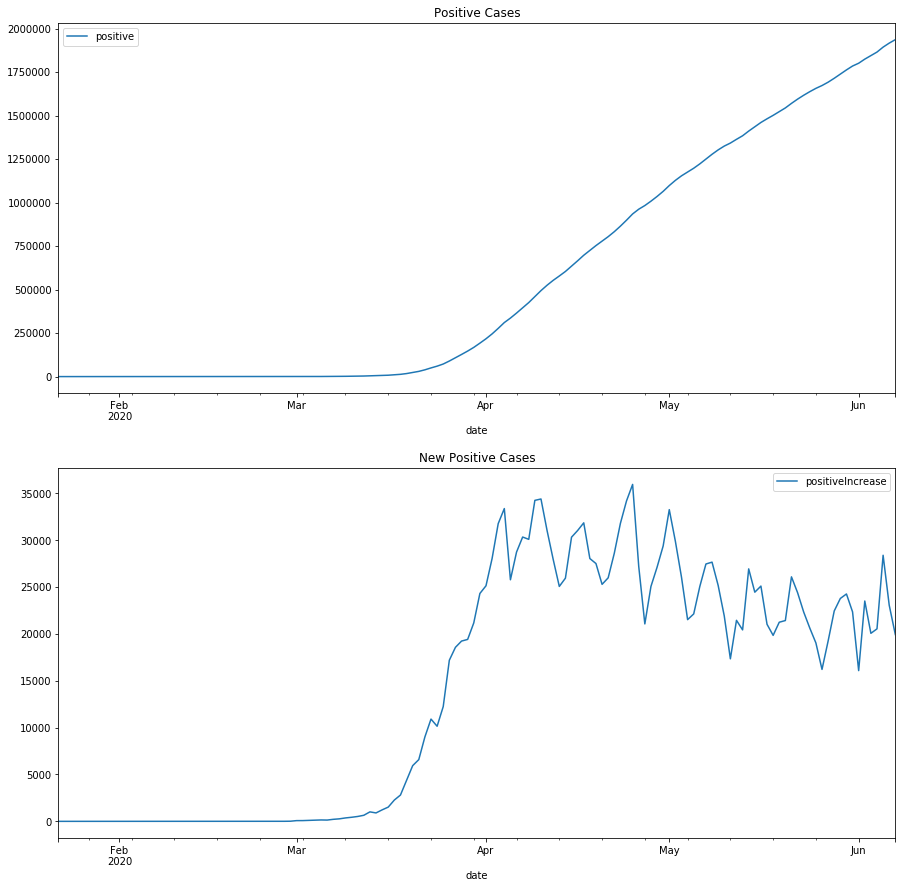

In [5]:
df_positive = df.groupby('date')['positive'].sum()
df_positiveIncrease = df.groupby('date')['positiveIncrease'].sum()

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15,15))
df_positive.plot(ax=axes[0], legend=True)
df_positiveIncrease.plot(ax=axes[1], legend=True)

axes[0].set_title('Positive Cases')
axes[1].set_title('New Positive Cases')

In the graph, we can notice that the number of cases from January to late March were relatively low and the growth rate was stable. Just starting April, we have an inflection point and the growth in positive cases start to increase drastically. During May, the marginal growth rate achieves its peak and then this marginal growth starts to dimish. What this means is that we still have a positive growth in the number of new cases but at a lower rate.

Based on that, it will be interesting to check what is the look of the natural logarithm function of these two variables. Let's plot the natural logarithm for Positive Cases and Total Deaths

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Ln New Positive Cases')

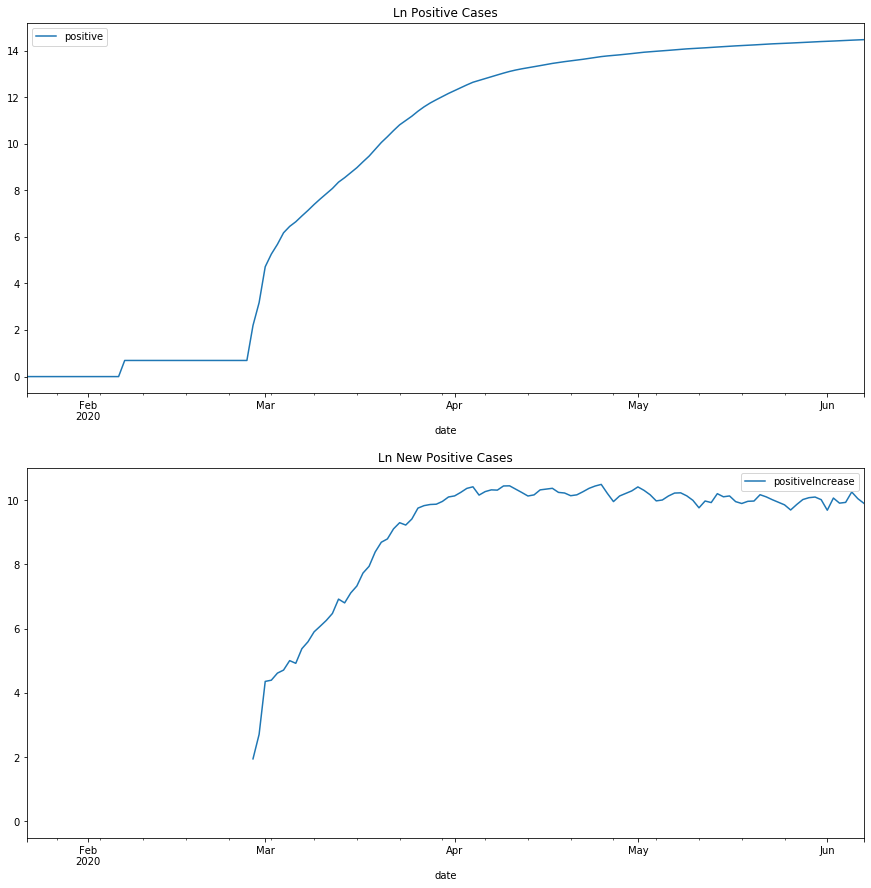

In [6]:
dfln_positive = np.log(df_positive)
dfln_positiveIncrease = np.log(df_positiveIncrease)

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15,15))
dfln_positive.plot(ax=axes[0], legend=True)
dfln_positiveIncrease.plot(ax=axes[1], legend=True)

axes[0].set_title('Ln Positive Cases')
axes[1].set_title('Ln New Positive Cases')

#### conclusion:
For positive new cases and total death, we clearly appreciate an exponential trend. This means that our model has to reflect this nonlinear feature in order to maximize accuracy in our forecast.

## Choosing the model

Now that we identified that our main variable, positive cases, follows an exponential trend let's find out what is the best model that could fit our data. But first, lest get a new data frame with only our two variables. The independent variable is time and our dependent variable is positive cases.

In [7]:
df = pd.read_csv('daily.csv')
df2 = df.groupby('date')['positive'].sum()
df2 = df_positive.to_frame()
df2.insert(0, 'time', range(0, len(df_positive)))
df2

,time,positive
date,,
2020-01-22,0,1.0
2020-01-23,1,1.0
2020-01-24,2,1.0
2020-01-25,3,1.0
2020-01-26,4,1.0
...,...,...
2020-06-03,133,1844235.0
2020-06-04,134,1864775.0
2020-06-05,135,1893167.0


In [8]:
x_data, y_data = (df2['time'].values, df2['positive'].values)

In my opinion a logistic function best suit the characteristics that we are looking. starting with a slow growth, increasing growth in the middle, and then decreasing again at the end. So let's define a function in the form of:

$$ \hat{Y} = \frac1{1+e^{\beta_1(X-\beta_2)}}$$

$\beta_1$: Controls the curve's steepness,

$\beta_2$: Slides the curve on the x-axis.

In [9]:
def sigmoid(x, Beta_1, Beta_2):
    y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
    return y

## Building the model

Finding the best parameters $\beta_1$ and $\beta_2$. Let's normalize first our data.

In [10]:
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

We can use __curve_fit__ to optimize the sigmoid function using non-linear least squares to fit our data

In [11]:
popt, pcov = curve_fit(sigmoid, xdata, ydata)
#print the final parameters
print(" beta_1 = %f, beta_2 = %f" % (popt[0], popt[1]))

 beta_1 = 9.680973, beta_2 = 0.705089


## Model evaluation

Once we obtained the most optimal parameters, we want to know how accurate our forecast will predict positive cases. Let's first take a look to the graphic representation between our data and the best fit line. 

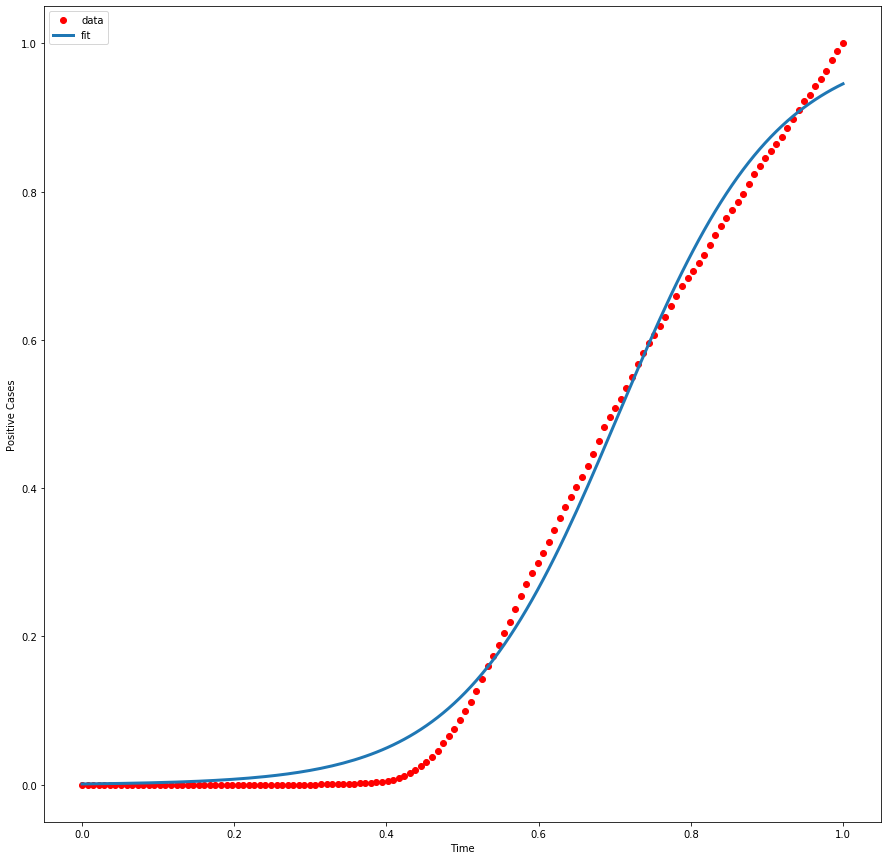

In [12]:
x = df2['time']
x = x/max(x)
plt.figure(figsize=(15,15))
y = sigmoid(x, *popt)
plt.plot(xdata, ydata, 'ro', label='data')
plt.plot(x,y, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('Positive Cases')
plt.xlabel('Time')
plt.show()

As we can see, the model fits really close to the variable that we want to predict. However, the inflection points seem to be critical. Let's calculate the Mean absolute error, MSE, and R2 of our model.

In [13]:
msk = np.random.rand(len(df2)) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata[msk]
test_y = ydata[~msk]

#build model using test data
popt, pcov = curve_fit(sigmoid, train_x, train_y)

#predict using test set
y_hat = sigmoid(test_x, *popt)

# evaluation
print("Mean absolute error: %.4f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.4f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.4f" % r2_score(y_hat , test_y) )

Mean absolute error: 0.0189
Residual sum of squares (MSE): 0.0006
R2-score: 0.9958


As notice above, The R2 is considerably high which means that our model has a strong predictive capacity.  The MSE is low which is in line with the result reflected in the R2.

## Forecast

We can generate the forecast using the sigmoid function defined above for the next 60 days

In [17]:
df_time = pd.DataFrame(columns=['time'])
for i in range(199):
    df_time = df_time.append({'time': i}, ignore_index=True)

x = df_time['time']
x = x/max(x)

print(x)

0               0
1      0.00505051
2        0.010101
3       0.0151515
4        0.020202
          ...    
194      0.979798
195      0.984848
196      0.989899
197      0.994949
198             1
Name: time, Length: 199, dtype: object


In [15]:
forecast = [sigmoid(x, *popt) for x in range(139,199)]
print(forecast)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


This numbers are not meaningful as we normalized our data before, we have to conver our data back to our starting units to have a more meaningful result. Due to time, I am only defining the function that will help to transfor our data to our original scale.

In [21]:
def detrans(forecast,beta_1,beta_2): 
    x = ((np.log(1-forecast))/forecast)/beta_1+beta_2
    return x

__Note:__ In order to get the number of new cases per day we will have to deduct the current period forecast minus the previous period forecast.

## Future Improvements:

- We could use the variable positive increase instead of total positive cases so we don't have to make many transformations at the end of our forecast. 

- We could run more test to identify Heteroskedasticity (non-constant variance in errors) or serial correlation (correlation in the time series) and make the appropriate correction based on findings.


*Elaborated by:* Mauricio Castro